In [66]:

import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X = mnist['data']
y = mnist['target']
print("shape of X :",X.shape , "shape of y :",y.shape)

shape of X : (70000, 784) shape of y : (70000,)


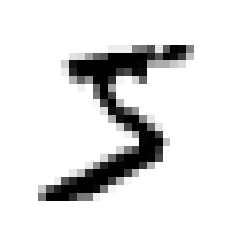

In [4]:
# 2차원 배열로 바꾸지 않으면 이미지를 그릴 수 없다.
image_0 = X[0].reshape(28,28)
plt.imshow(image_0,cmap="binary")
plt.axis("off")
plt.show()

In [5]:
# 타겟값 정수형으로 변경
y = y.astype(np.int8)

In [6]:
#훈련 세트와 테스트 세트 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### 3.2 이진분류기 훈련

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([X[0]])

array([ True])

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### 3.3 성능 측정

#### 3.3.1 교차 검증을 사용한 정확도 측정

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)



for train_idx , test_idx in skfolds.split(X_train,y_train_5):
    x_train_fold = X_train[train_idx]
    y_train_fold = y_train_5[train_idx]
    
    x_test_fold = X_train[test_idx]
    y_test_fold = y_train_5[test_idx]
    
    clone_clf = clone(sgd_clf)
    clone_clf.fit(x_train_fold,y_train_fold)
    y_pred = clone_clf.predict(x_test_fold)
    
    # E(X) = P(X=1) / X~Ber(p)
    print( np.mean( (y_pred == y_test_fold).astype(int) ) )
    

0.9669
0.91625
0.96785


In [12]:
y_train_5.astype(int)

array([1, 0, 0, ..., 1, 0, 0])

In [13]:
#모든 이미지를 '5'가 아니라고 분류함 ( this clf predicts 0 for all data)
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    
    def predict(self,X):
        return np.zeros( (len(X),1) ,dtype=bool )

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

#### 3.3.2 오차행렬

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
# [ [TN,FP] , [FN,TP] ]
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

#### 3.3.3 정밀도와 재현율

In [17]:
from sklearn.metrics import precision_score, recall_score

# 정밀도 = TP / FP + TP , Positive라고 예측한 것에 대한 True Positive의 비율
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
# 재현율 = TP / FN + TP , 실제 양성인 것에 대한 True Positive의 비율 
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
# F1 점수 = 정밀도와 재현율의 조화평균 
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### 3.3.4 정밀도/재현율의 Trade Off

정밀도와 재현율의 차이는 FP 와 FN 의 차이에서 나온다.
임계값을 높히면 양성의 예측은 작아지고 음성의 예측은 많아진다.

In [21]:
y_scores = sgd_clf.decision_function([X[0]])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [36]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

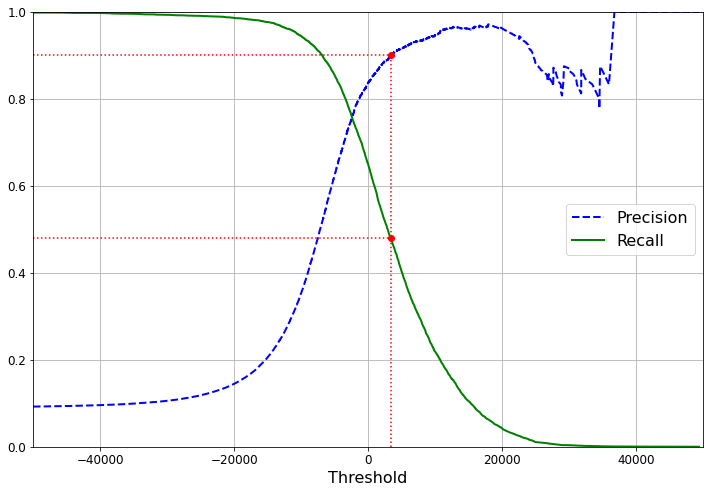

In [44]:
plt.figure(figsize=(12,8))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:") 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")   
plt.legend(loc="center right", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)        
plt.grid(True)                              
plt.axis([-50000, 50000, 0, 1])            
plt.show()


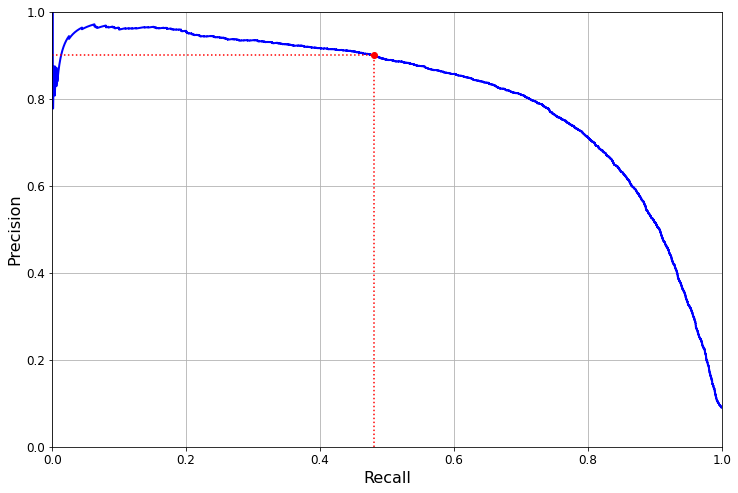

In [51]:
plt.figure(figsize=(12,8))
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.plot([0,recall_90_precision],[0.9,0.9],'r:')
plt.plot([recall_90_precision,recall_90_precision],[0.,0.9],'r:')
plt.plot([recall_90_precision], [0.9], "ro")  
plt.xlabel("Recall", fontsize=16)       
plt.ylabel("Precision", fontsize=16)
plt.grid(True)                             
plt.axis([0.0, 1.0, 0.0, 1.0])            

#### 3.3.5 ROC곡선

In [52]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

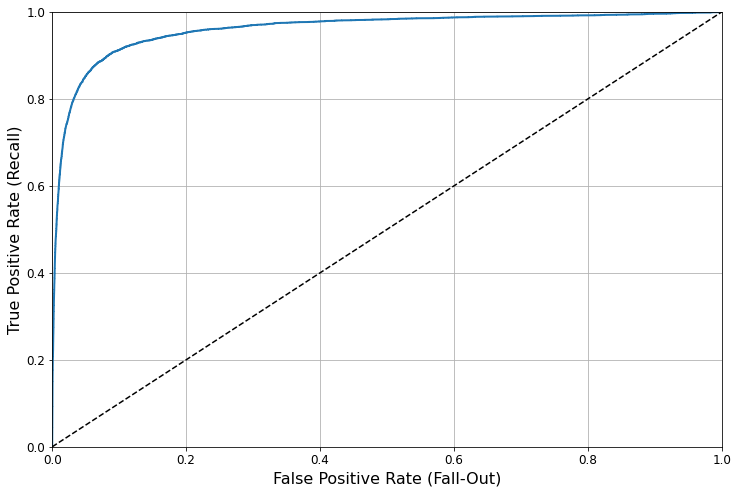

In [55]:
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr,linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # 대각 점선


plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
plt.ylabel("True Positive Rate (Recall)", fontsize=16)    
plt.axis([0.0, 1.0, 0.0, 1.0])
           
plt.grid(True)                                     
plt.show()

In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [58]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

In [62]:
y_proba_forest[:,1]

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

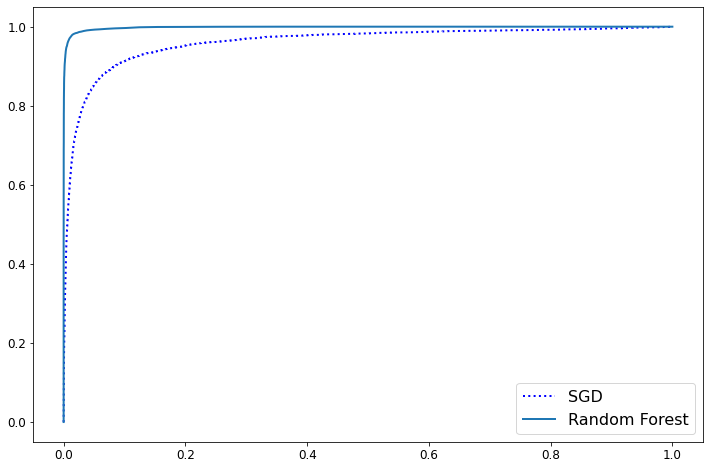

In [65]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_proba_forest[:,1])
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, "b:",label = "SGD", linewidth=2)
plt.plot(fpr_forest, tpr_forest,label = "Random Forest",linewidth=2)
plt.legend(loc="lower right", fontsize=16)
plt.show()